In [3]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming
from scipy.optimize import linear_sum_assignment
from time import time
from matplotlib import animation, rc
from shapely.geometry import Polygon, Point
from shapely.geometry.polygon import LinearRing

sns.set()
# Import Tabu Sampler
from tabu_class import tabu_sampler

@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

%matplotlib inline


In [4]:
adjustment_power = 4
adjustment_factor = 10**adjustment_power

points = np.asarray([(0, 20), (0, 130), (20, 150), (170, 150),
                    (190, 130), (190, 20), (170, 0), (20, 0)])/adjustment_factor
field = np.asarray([(37.5, 40), (37.5, 110), (152.5, 110), (152.5, 40), (37.5, 40)])/adjustment_factor

field_ring = LinearRing(field)
#points = points/100

building_polygon = Polygon(points, holes=[field_ring])

n = 12500

building_coords = list(building_polygon.exterior.coords)

# Use points to construct a new placeholder
coord = np.asarray(building_coords)

people_positions = np.zeros((n, 2))

#minx, miny, maxx, maxy = building_polygon.bounds

for i in np.arange(n):
    state_ = True
    
    point = Point(np.round(np.random.normal(size=1, scale=50/adjustment_factor, loc=10*95/adjustment_factor), adjustment_power), 
                  np.round(np.random.normal(size=1, scale=45/adjustment_factor, loc=10*75/adjustment_factor), adjustment_power))
        
    while state_:
        if building_polygon.contains(point):
            people_positions[i, 0] = point.x
            people_positions[i, 1] = point.y
            state_ = False
        else:
            point = Point(np.round(np.random.normal(size=1, scale=50/adjustment_factor, loc=95/adjustment_factor), adjustment_power), 
                          np.round(np.random.normal(size=1, scale=45/adjustment_factor, loc=75/adjustment_factor), adjustment_power))
            
    state_ = True

print("Number of (unique) spectators:", np.unique(people_positions, axis=0).shape[0])
n = np.unique(people_positions, axis=0).shape[0]
    
people_positions = np.unique(people_positions, axis=0)
    
# Build sensor grid
sensor_locations = np.asarray([0, 0])

for i in np.arange(0, 190/adjustment_factor, 5/adjustment_factor):
    for j in np.arange(0, 150/adjustment_factor, 5/adjustment_factor):
        current_point = Point(i, j)
        
        if building_polygon.contains(current_point):
            sensor_locations = np.vstack((sensor_locations, [i, j]))
            
sensor_locations = np.delete(sensor_locations, 0, axis=0)      

no_points = sensor_locations.shape[0]

# Kernel function to determine utility
def kernel_function(x, y):
    return np.exp(-2*adjustment_factor * np.sum((x-y)**2))

facility_value = np.zeros((n, no_points))

# Calculate euclidean distance to access point
for i in np.arange(n):
    for j in np.arange(no_points):
        facility_value[i, j] = kernel_function(people_positions[i, :], sensor_locations[j, :])#np.linalg.norm(people_positions[i, :] - sensor_locations[j, :])

lambda_val = 0.5
beta = 1
alpha = 0.1
capacity = 10

Number of (unique) spectators: 8746


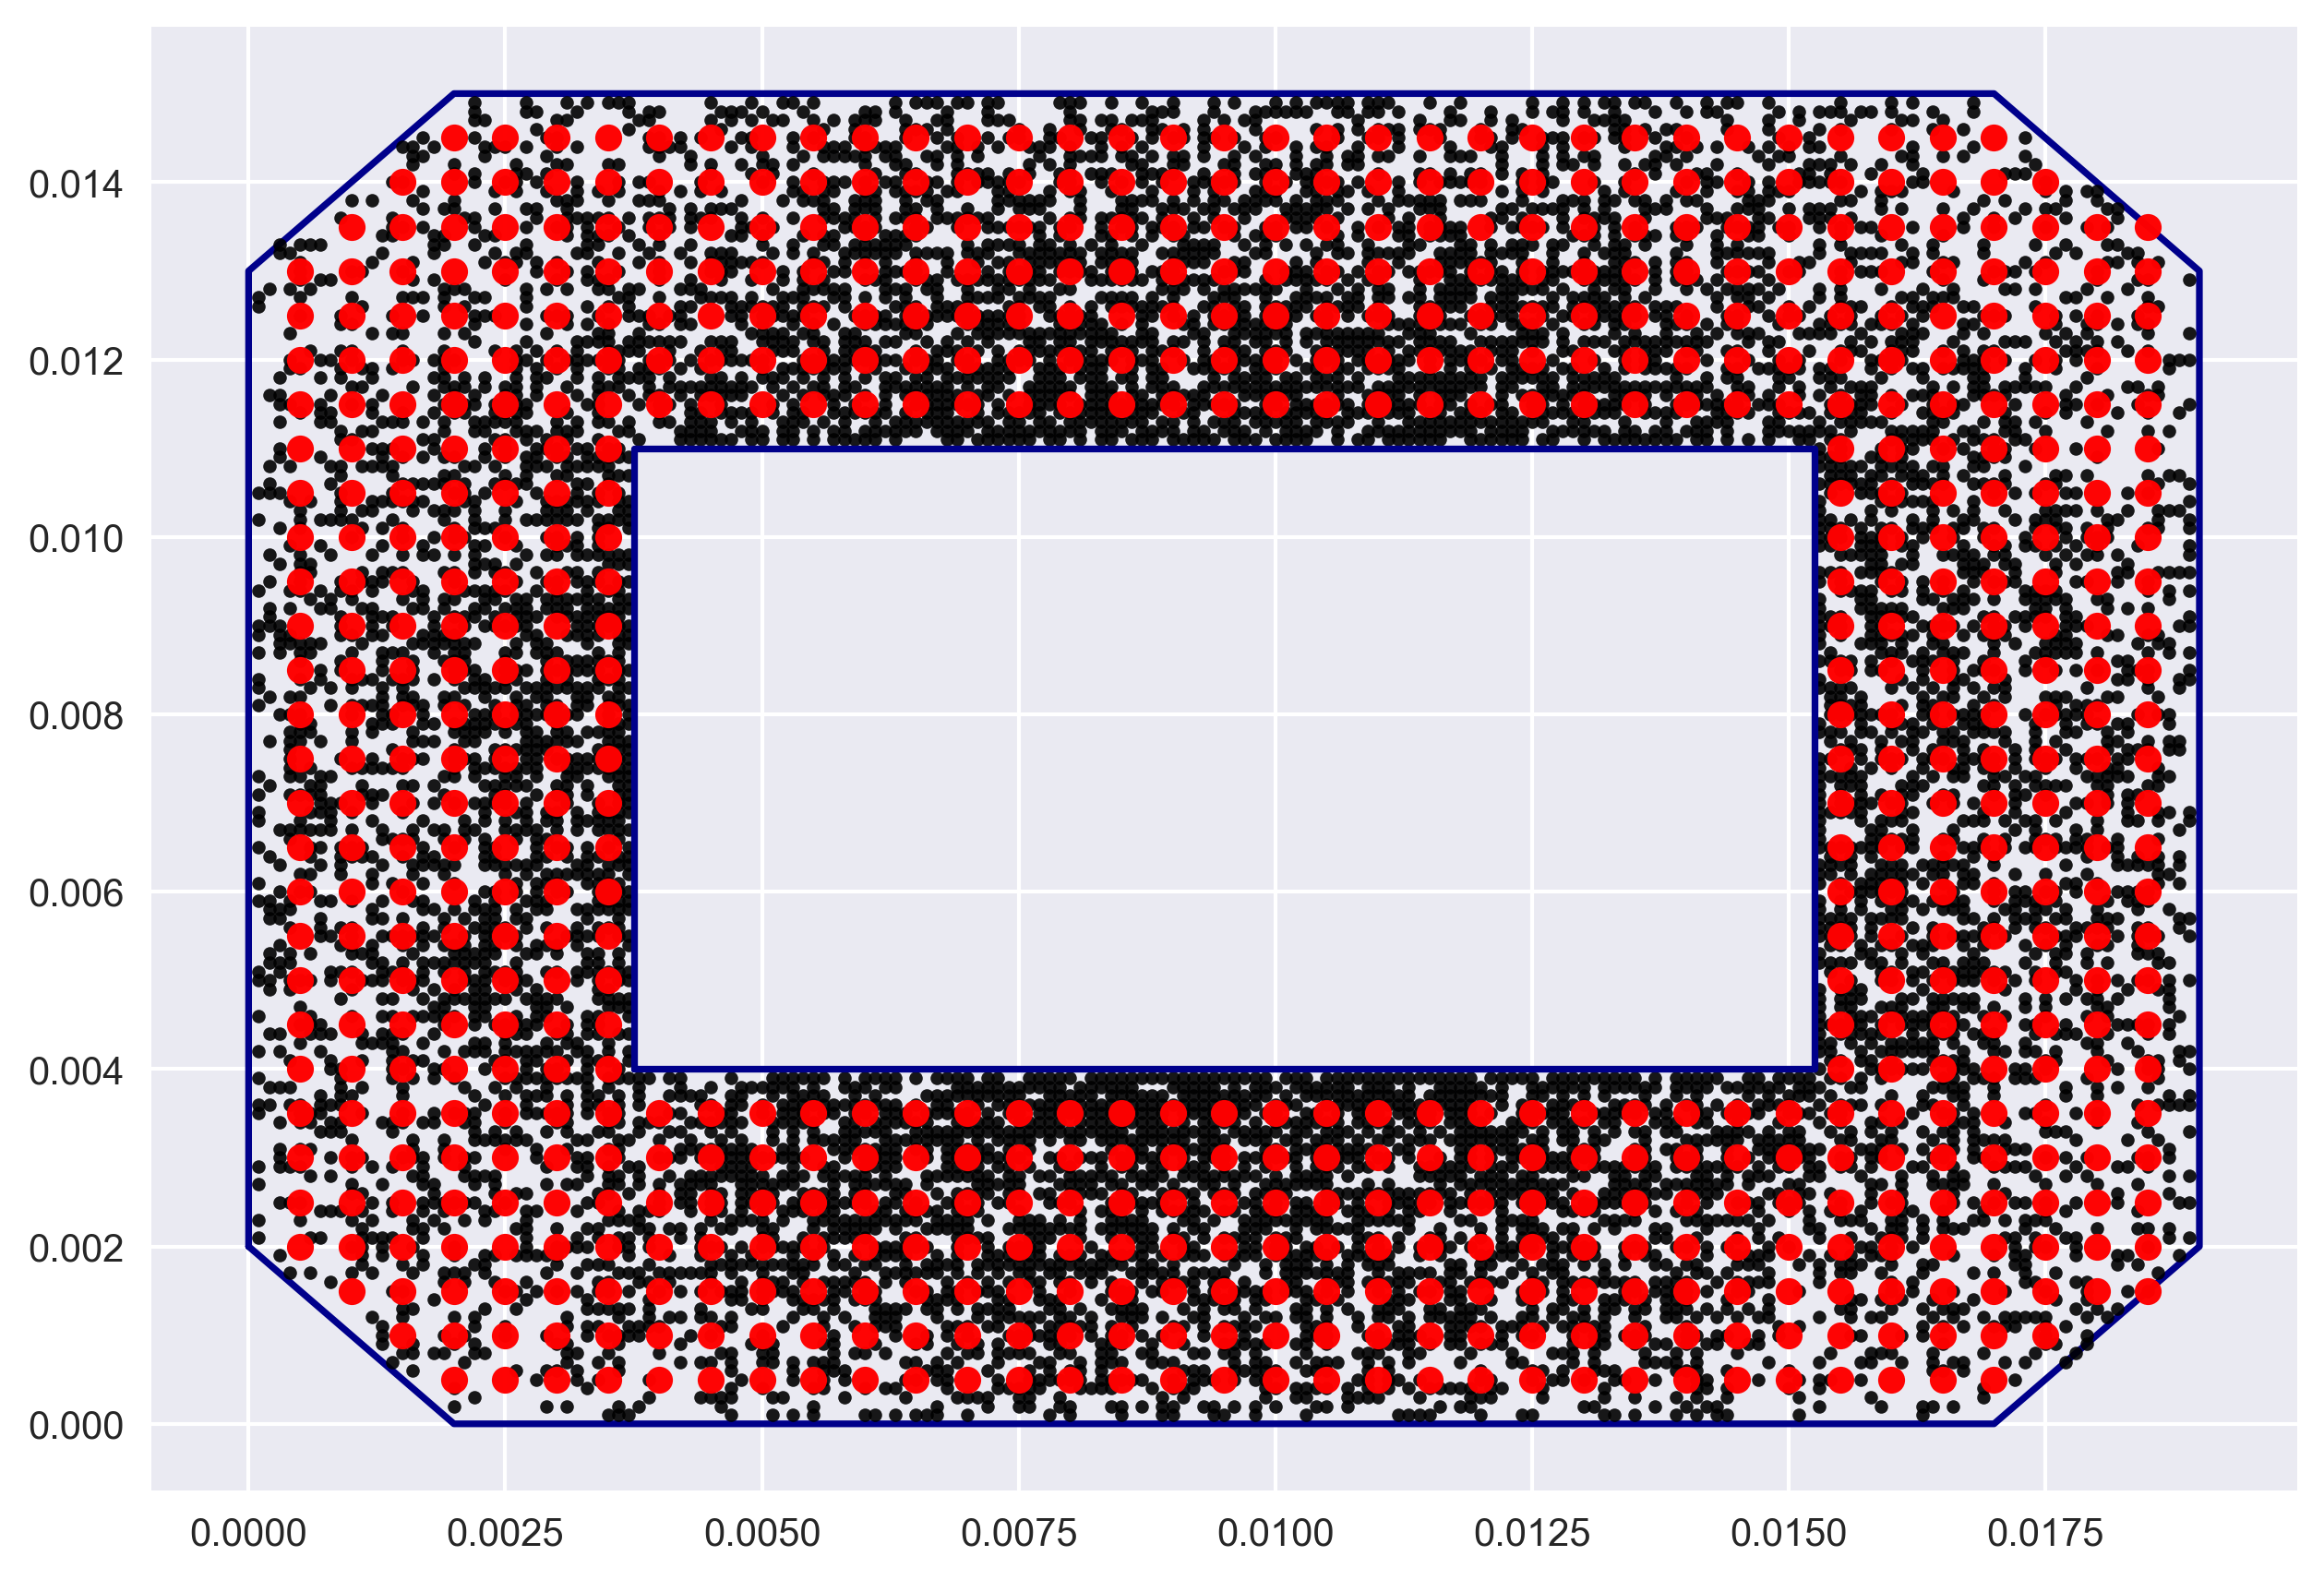

In [5]:
%matplotlib inline
plt.figure(figsize=(10,7), dpi=300)
plt.plot(coord[:, 0], coord[:, 1], color="darkblue")
plt.plot(people_positions[:, 0], people_positions[:, 1], ".", color="k", alpha=0.9)
plt.plot(sensor_locations[:, 0], sensor_locations[:, 1], "o", color="red", alpha=5)

plt.plot(field[:, 0], field[:, 1], color="darkblue")
#plt.plot(sensor_locations[np.nonzero(np.ravel(samples[310]))[0], 0], sensor_locations[np.nonzero(np.ravel(samples[310]))[0], 1], "o", color="yellow")
#plt.plot(people_positions[1000, 0], people_positions[1000, 1], "o", color="yellow")


In [6]:
initial_state = np.random.choice([0,1], no_points)
current_utility = np.zeros(n)
sensor_choice = np.zeros(n)
possible_sensor_choices = np.zeros((no_points, n))
sensor_users = np.zeros(no_points)
possible_sensor_users = np.zeros((no_points, no_points))

def energy_func(state):
    if np.sum(state) == 0:
        return 0
    else: 
        indices = np.nonzero(np.ravel(state))[0]
        
        sensor_users[:] = np.zeros(no_points)

        energy = 0
        
        for i in np.arange(n):
            sensor_chosen = np.argmax(facility_value[i, indices])
            sensor_users[int(indices[sensor_chosen])] += 1
            sensor_choice[i] = int(indices[sensor_chosen])
            utility_gained = facility_value[i, sensor_chosen]
            energy += utility_gained
            current_utility[i] = utility_gained        

        # Cost of installing the sensors
        energy -= lambda_val * indices.shape[0]
        # Cost of over-use of sensors with too many sensors in vicinity
        #cost_of_exceeding = (alpha*(sensor_users > capacity)*(sensor_users-capacity)).sum()
        #energy -= cost_of_exceeding
        
        return energy  

def calc_rates(state, jump_rates=0, jump_rates_sum=0, generator_index=0):
    initial_energy = energy_func(state)
    rate_vector = np.zeros(no_points)

    for j in np.arange(no_points):
        # Set energy to 0
        energy = initial_energy

        # Turn sensor on or off
        flipped_state = state.copy()
        flipped_state[j] = 1 - flipped_state[j]

        # Return possible indices after turning off sensor
        indices = np.nonzero(np.ravel(flipped_state))[0]

        # Insert current sensor choice array into possible states
        possible_sensor_choices[j, :] = sensor_choice
        
        # Insert current user statistics into possible user configurations
        possible_sensor_users[j, :] = sensor_users
        
        # Brute-adjustment of energy from exceeded capcity
        #energy += (alpha*(sensor_users > capacity)*(sensor_users-capacity)).sum()

        # If we are turning off a sensor
        if state[j] == 1:
            # Set number of users of sensor j to 0
            possible_sensor_users[j, j] = 0
            
            # Iterate over spectators that have lost their best sensor
            for i in np.nonzero(np.ravel(sensor_choice == j))[0]:
                # Find best second choice sensor
                sensor_chosen = np.argmax(facility_value[i, indices])
                # Save sensor choice placeholder
                new_sensor_choice = int(indices[sensor_chosen])
                # Add a user to the chosen sensor
                possible_sensor_users[j, new_sensor_choice] += 1
                # Update the users choice
                possible_sensor_choices[j, i] = new_sensor_choice

                # Add difference to energy
                energy += facility_value[i, new_sensor_choice] - facility_value[i, int(sensor_choice[i])]

            # Cost of removing a sensor
            energy += lambda_val
            
            # Cost of exceeded capacity
            #energy -= (alpha*(possible_sensor_users[j, :] > capacity)*(possible_sensor_users[j, :]-capacity)).sum()

        # If we are turning on a sensor
        else:
            # Iterate over spectators that have gained an even closer sensor
            for i in np.nonzero(np.ravel(facility_value[np.arange(n), sensor_choice.astype("int")] < facility_value[:, j]))[0]:
                # increase in energy from finding a better sensor
                energy += facility_value[i, j] - facility_value[i, sensor_choice[i].astype("int")]
                
                # Set the chosen sensor as the new possible choice if this group action is chosen
                possible_sensor_choices[j, i] = j
                
                # Decline in users for sensor that was previously chosen
                possible_sensor_users[j, sensor_choice[i].astype("int")] -= 1
                
                # Increase in users for sensor turned on
                possible_sensor_users[j, j] += 1

            # Cost of adding a sensor
            energy -= lambda_val
            
            # Cost of exceeded capacity
            #energy -= (alpha*(possible_sensor_users[j, :] > capacity)*(possible_sensor_users[j, :]-capacity)).sum()
        
        rate_vector[j] = np.exp(-beta/2 * (energy - initial_energy))
        
    return rate_vector

def calc_rates_barker(state, jump_rates=0, jump_rates_sum=0, generator_index=0):
    initial_energy = energy_func(state)
    rate_vector = np.zeros(no_points)

    for j in np.arange(no_points):
        # Set energy to 0
        energy = initial_energy

        # Turn sensor on or off
        flipped_state = state.copy()
        flipped_state[j] = 1 - flipped_state[j]

        # Return possible indices after turning off sensor
        indices = np.nonzero(np.ravel(flipped_state))[0]

        # Insert current sensor choice array into possible states
        possible_sensor_choices[j, :] = sensor_choice
        
        # Insert current user statistics into possible user configurations
        possible_sensor_users[j, :] = sensor_users
        
        # Brute-adjustment of energy from exceeded capcity
        #energy += (alpha*(sensor_users > capacity)*(sensor_users-capacity)).sum()

        # If we are turning off a sensor
        if state[j] == 1:
            # Set number of users of sensor j to 0
            possible_sensor_users[j, j] = 0
            
            # Iterate over spectators that have lost their best sensor
            for i in np.nonzero(np.ravel(sensor_choice == j))[0]:
                # Find best second choice sensor
                sensor_chosen = np.argmax(facility_value[i, indices])
                # Save sensor choice placeholder
                new_sensor_choice = int(indices[sensor_chosen])
                # Add a user to the chosen sensor
                possible_sensor_users[j, new_sensor_choice] += 1
                # Update the users choice
                possible_sensor_choices[j, i] = new_sensor_choice

                # Add difference to energy
                energy += facility_value[i, new_sensor_choice] - facility_value[i, int(sensor_choice[i])]

            # Cost of removing a sensor
            energy += lambda_val
            
            # Cost of exceeded capacity
            #energy -= (alpha*(possible_sensor_users[j, :] > capacity)*(possible_sensor_users[j, :]-capacity)).sum()

        # If we are turning on a sensor
        else:
            # Iterate over spectators that have gained an even closer sensor
            for i in np.nonzero(np.ravel(facility_value[np.arange(n), sensor_choice.astype("int")] < facility_value[:, j]))[0]:
                # increase in energy from finding a better sensor
                energy += facility_value[i, j] - facility_value[i, sensor_choice[i].astype("int")]
                
                # Set the chosen sensor as the new possible choice if this group action is chosen
                possible_sensor_choices[j, i] = j
                
                # Decline in users for sensor that was previously chosen
                possible_sensor_users[j, sensor_choice[i].astype("int")] -= 1
                
                # Increase in users for sensor turned on
                possible_sensor_users[j, j] += 1

            # Cost of adding a sensor
            energy -= lambda_val
            
            # Cost of exceeded capacity
            #energy -= (alpha*(possible_sensor_users[j, :] > capacity)*(possible_sensor_users[j, :]-capacity)).sum()
        
        rate_vector[j] = 1/(1+np.exp(beta * (initial_energy-energy)))
        
    return rate_vector
        
    
def apply_gen(state, generator_index):
    updated_state = state.copy()
    updated_state[generator_index] = 1 - updated_state[generator_index]
    
    # insert the current correct sensor choices into  
    sensor_choice = possible_sensor_choices[generator_index, :]
    
    return updated_state

In [7]:
# Barker
T=5
thinning_ratio = 0.005
# Squareroot
#T = 3
#thinning_ratio = 0.003
N = int(T/thinning_ratio)
print("Number of samples to be generated:", N)

samples, energy, hammings, alpha, iters, runtime = tabu_sampler(no_points, no_points,
                                                              energy_function=energy_func,
                                                              calculate_rates=calc_rates_barker,
                                                              update_rates=calc_rates_barker,
                                                              apply_generator=apply_gen,
                                                              current_state=np.ones(no_points),
                                                              baseline_state=np.ones(no_points),
                                                              target_time=T,
                                                              thin_rate=thinning_ratio,
                                                              time_change_rate=10e-10,
                                                              symmetry=False,
                                                              SAW_bool=True,
                                                              print_output=False,
                                                              calc_hamming=False,
                                                              calc_energy=True)

# Update type of samples
samples = samples.astype("int8") 

Number of samples to be generated: 1000
Percent: [------------------------------------>   ] 92%[5.00340287]
Average Excursion: 53.0
Average jump length: [0.00468045]
Runtime: 310.16


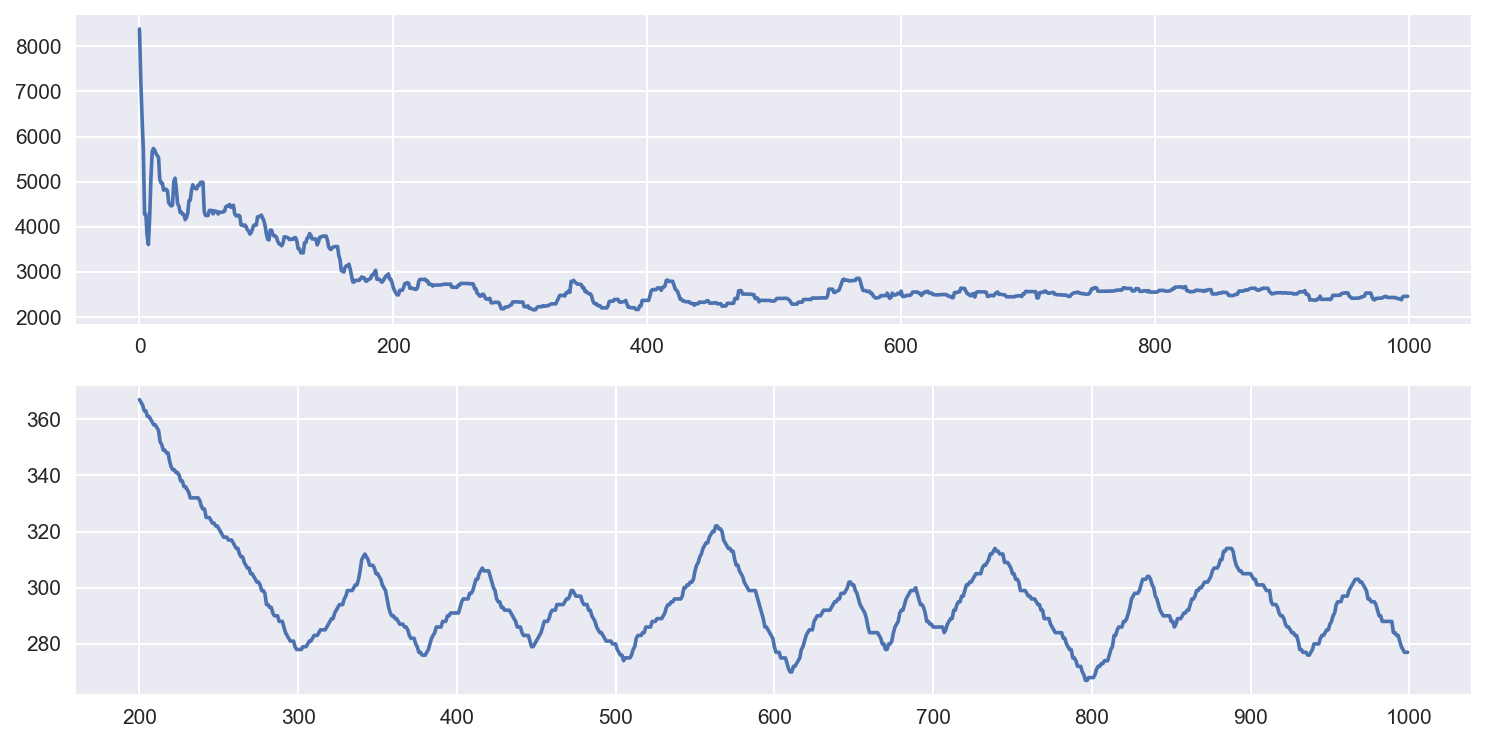

In [8]:
%matplotlib inline
plt.figure(figsize=(12,6), dpi=150)
ax1 = plt.subplot(211)
ax1.plot(np.arange(0, N), energy)
ax2 = plt.subplot(212)
ax2.plot(np.arange(int(0.2*N), N), samples.sum(axis=1)[int(0.2*N):])

Total ESS: 500.0000000000159
ESS/S: 1.6120626295654787


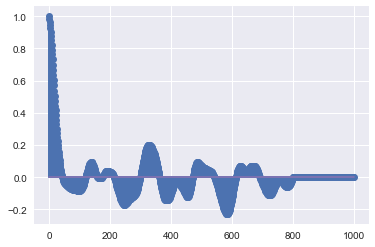

In [9]:
fig, ax = plt.subplots()
ax.stem(autocorr(samples.sum(axis=1)[int(0.2*N):], np.arange(0, 1000)))
ESS_E = N/(1+2*sum(autocorr(samples.sum(axis=1)[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime)

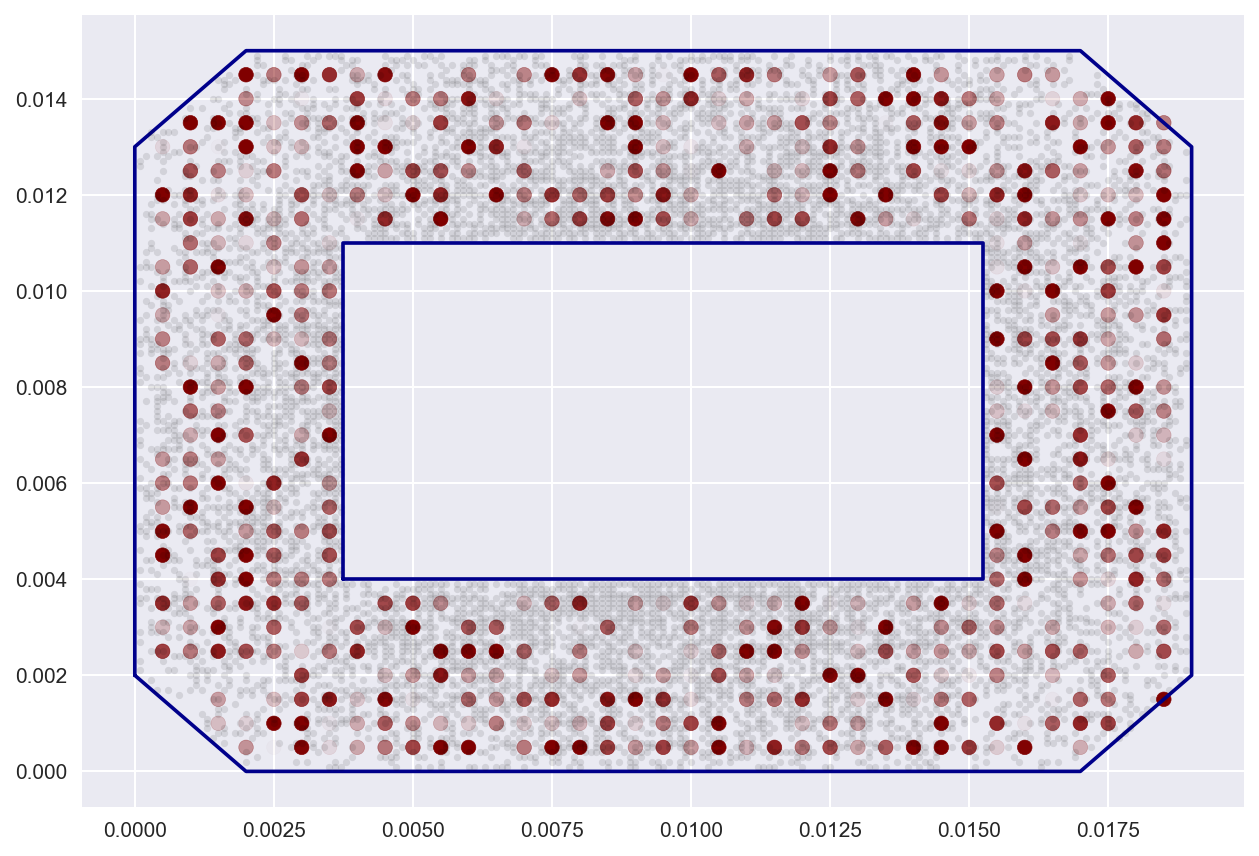

In [10]:
%matplotlib inline
rgbc = np.zeros((no_points, 4))
rgbc[:, 0] = 0.5
rgbc[:, 3] = samples[int(0.2*N):, ].sum(axis=0)/(0.8*N)
plt.figure(figsize=(10,7), dpi=150)
plt.plot(coord[:, 0], coord[:, 1], color="darkblue")
plt.plot(people_positions[:, 0], people_positions[:, 1], ".", color="k", alpha=0.1)
plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], color=rgbc)
plt.plot(field[:, 0], field[:, 1], color="darkblue")
#plt.plot(sensor_locations[np.nonzero(np.ravel(samples[310]))[0], 0], sensor_locations[np.nonzero(np.ravel(samples[310]))[0], 1], "o", color="yellow")
#plt.plot(people_positions[1000, 0], people_positions[1000, 1], "o", color="yellow")


In [11]:
T = 2.5
thinning_ratio = 0.0025
N = int(T/thinning_ratio)
print("Number of samples to be generated:", N)

samples_z, energy_z, hammings, alpha, iters, runtime_z = tabu_sampler(no_points, no_points,
                                                              energy_function=energy_func,
                                                              calculate_rates=calc_rates_barker,
                                                              update_rates=calc_rates_barker,
                                                              apply_generator=apply_gen,
                                                              current_state=np.ones(no_points),
                                                              baseline_state=np.ones(no_points),
                                                              target_time=T,
                                                              thin_rate=thinning_ratio,
                                                              time_change_rate=10,
                                                              symmetry=False,
                                                              SAW_bool=False,
                                                              print_output=False,
                                                              print_rate=100,
                                                              calc_hamming=False)

# Update type of samples
samples_z = samples_z.astype("int8") 

Number of samples to be generated: 1000
Percent: [------------------------------------>   ] 92%[2.50402871]
Average jump length: [0.00256823]
Runtime: 277.04


Total ESS: 499.9999999999676
ESS/S: 1.8047858575793758


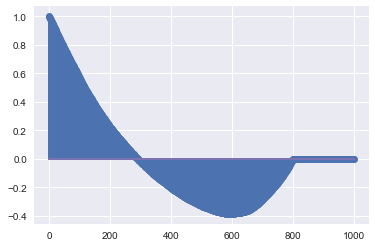

In [13]:
fig, ax = plt.subplots()
ax.stem(autocorr(samples_z[int(0.2*N):].sum(axis=1), np.arange(0, 1000)))
ESS_E = N/(1+2*sum(autocorr(samples_z[int(0.2*N):].sum(axis=1), np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime_z)

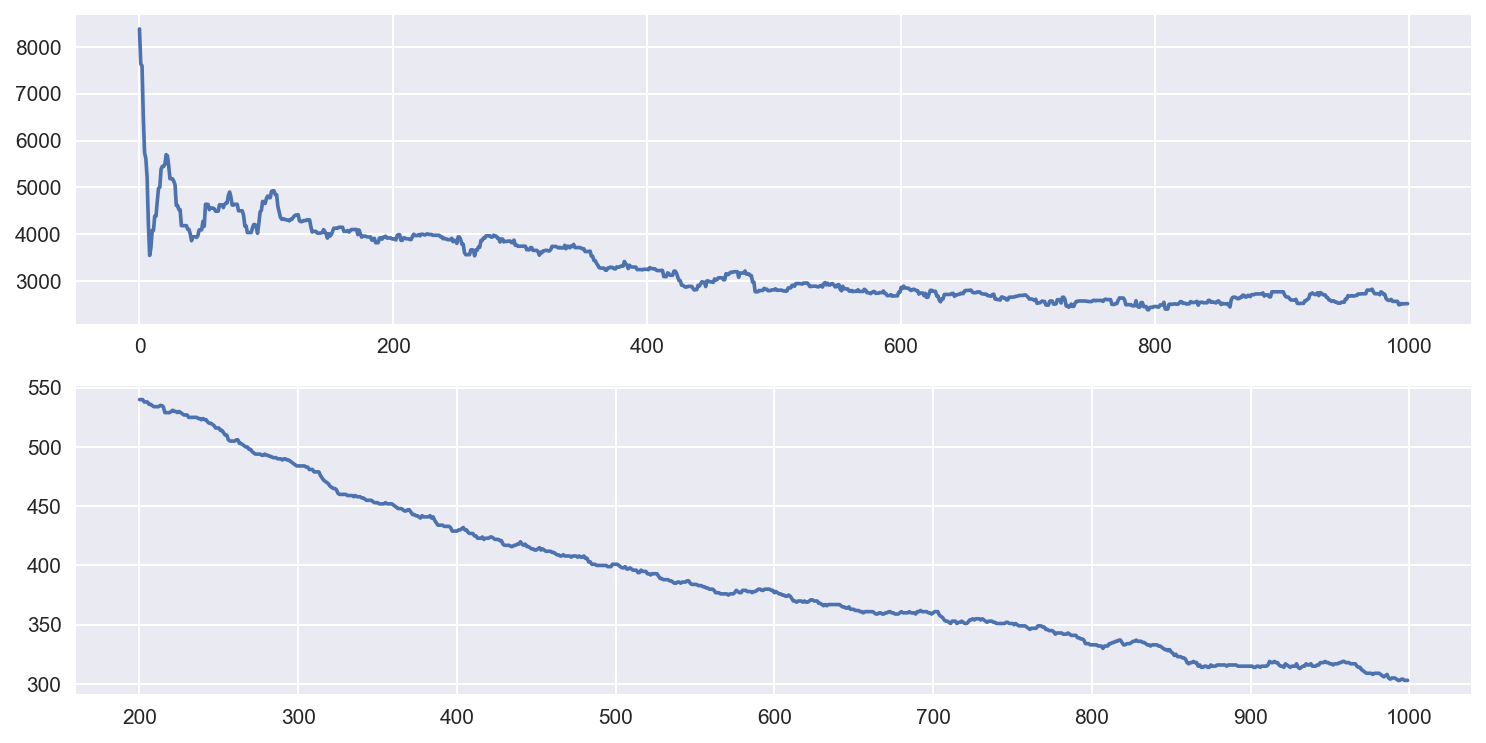

In [14]:
plt.figure(figsize=(12,6), dpi=150)
ax1 = plt.subplot(211)
ax1.plot(np.arange(0, N), energy_z)
ax2 = plt.subplot(212)
ax2.plot(np.arange(int(0.2*N), N), samples_z.sum(axis=1)[int(0.2*N):])